<a href="https://colab.research.google.com/github/FatmaBuseBorlu/Dramer-Dataset/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En İyi Doğruluk Değerine Sahip Kod

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [ ]:
# DREAMER veri kümesini yükleme fonksiyonu
def load_dreamer_data(file_path):
    data = sio.loadmat(file_path)
    eeg_data = []
    labels = []
    for participant in range(23):  # 23 katılımcı
        for video in range(18):  # 18 video
            # EEG verilerini al
            baseline = data['DREAMER'][0, 0]['Data'][0, participant]['EEG'][0, 0]['baseline'][0, 0][video, 0]
            stimuli = data['DREAMER'][0, 0]['Data'][0, participant]['EEG'][0, 0]['stimuli'][0, 0][video, 0]

            if stimuli.size == 0:
                print(f"Uyarı: Katılımcı {participant}, video {video} için boş stimuli verisi. Atlanıyor.")
                continue

            if stimuli.shape[0] != 14:
                stimuli = stimuli.T  # Gerekirse transpoze et

            eeg_data.append(stimuli)
            labels.append(data['DREAMER'][0, 0]['Data'][0, participant]['ScoreValence'][0, 0][video, 0])  # Valence

    return eeg_data, np.array(labels)
    # EEG verilerini ön işleme
def preprocess_eeg_data(eeg_data):
    max_length = max(sample.shape[1] for sample in eeg_data)

    padded_eeg_data = []
    for sample in eeg_data:
        if sample.shape[1] < max_length:
            padding_shape = ((0, 0), (0, max_length - sample.shape[1]))
            padded_sample = np.pad(sample, padding_shape, mode='constant', constant_values=0)
        else:
            padded_sample = sample
        padded_eeg_data.append(padded_sample)

    eeg_data = np.array(padded_eeg_data)
    eeg_data = eeg_data[:, :, :, np.newaxis]  # CNN için (örnek, zaman, kanal, 1)
    scaler = StandardScaler()
    eeg_data = eeg_data.reshape(eeg_data.shape[0], -1)  # 2D hale getir
    eeg_data = scaler.fit_transform(eeg_data)
    eeg_data = eeg_data.reshape(-1, eeg_data.shape[1] // 14, 14, 1)

    return eeg_data

In [ ]:
# Veri yükleme ve ön işleme
file_path = "/content/drive/MyDrive/Colab Notebooks/DREAMER.mat"
eeg_data, labels = load_dreamer_data(file_path)
eeg_data = preprocess_eeg_data(eeg_data)

In [ ]:
# Etiketleri binary sınıflandırma için düzenleme
labels = LabelEncoder().fit_transform(labels > 5)
if len(np.unique(labels)) == 1:
    eeg_data = np.concatenate([eeg_data, eeg_data], axis=0)
    labels = np.concatenate([labels, 1 - labels], axis=0)

labels = to_categorical(labels)

In [ ]:
# Eğitim ve test verisine ayırma
X_train, X_test, y_train, y_test = train_test_split(eeg_data, labels, test_size=0.2, random_state=42)

In [ ]:
# Geliştirilmiş CNN modeli
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(eeg_data.shape[1], eeg_data.shape[2], 1)),  # padding='same' eklendi
    BatchNormalization(),  # Batch normalization ekleme
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', padding='same'),  # padding='same' eklendi
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),  # padding='same' eklendi
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # İkili sınıflandırma
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Modeli derleme
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Modeli eğitme
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 364ms/step - accuracy: 0.5174 - loss: 228.9380 - val_accuracy: 0.4737 - val_loss: 252.5647
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.5339 - loss: 70.3387 - val_accuracy: 0.4662 - val_loss: 205.9339
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.5219 - loss: 17.0026 - val_accuracy: 0.4662 - val_loss: 147.1774
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.4861 - loss: 6.0212 - val_accuracy: 0.4737 - val_loss: 105.8500
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.5695 - loss: 1.9656 - val_accuracy: 0.4737 - val_loss: 82.8288
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.4804 - loss: 0.7255 - val_accuracy: 0.4662 - val_loss: 67.9450
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.4877 - loss: 0.6957 - val_accuracy: 0.4586 - val_loss: 53.1962
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.4651 - loss: 0.6954 - val_acc

In [ ]:
# Modeli değerlendirme
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

6/6 - 7s - 1s/step - accuracy: 0.4699 - loss: 0.7770
Test Loss: 0.7770451903343201
Test Accuracy: 0.46987950801849365


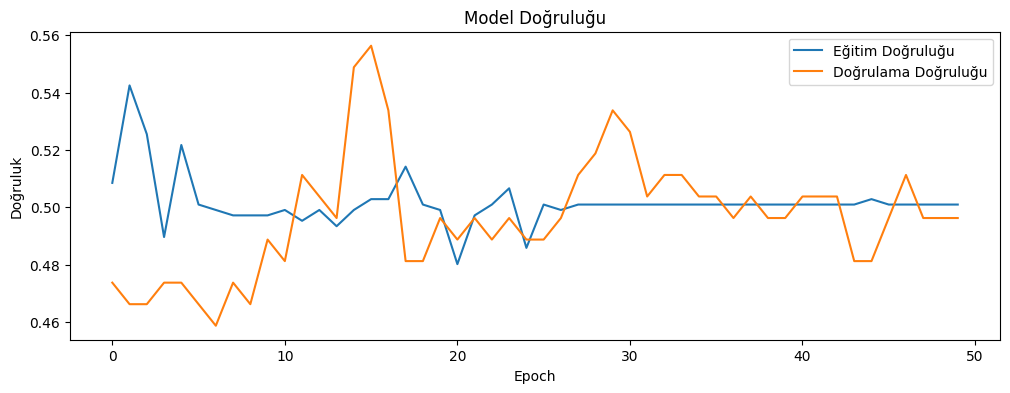

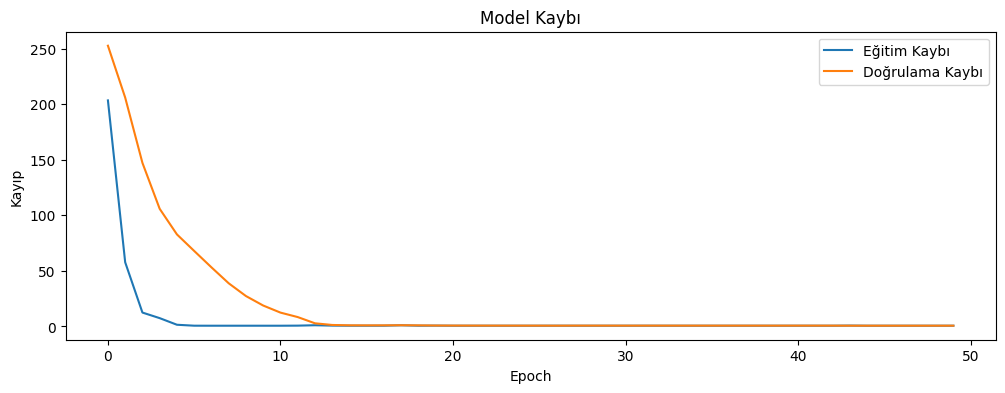

In [ ]:
# Eğitim ve doğrulama doğruluğunu çiz
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

# Eğitim ve doğrulama kaybını çiz
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()
